In [41]:
library(limma)
library(GEOquery)
library(pheatmap)
library(readr)

options(repr.matrix.max.cols=50, repr.matrix.max.rows=15)

####  Import

In [ ]:
gset <- getGEO("GSE28619", GSEMatrix =TRUE, AnnotGPL=TRUE)
if (length(gset) > 1) idx <- grep("GPL570", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

#### Set group

In [4]:
# make proper column names to match toptable 
fvarLabels(gset) <- make.names(fvarLabels(gset))

#get group
gp <- pData(gset)$'liver sample group:ch1'
gp <- sub(': ', '', gp)
gp <- sub(' ', '_', gp)
groups <-make.names(levels(factor(gp)))
gset$group <- gp

#### Preprocessing: summary, boxplot (assess distribution), KDE

In [5]:
summary(exprs(gset)) # VALUE = log2 gcrma (normalisation) signal intensity

   GSM709348        GSM709349        GSM709350        GSM709351     
 Min.   : 2.323   Min.   : 2.323   Min.   : 2.323   Min.   : 2.323  
 1st Qu.: 2.323   1st Qu.: 2.323   1st Qu.: 2.323   1st Qu.: 2.323  
 Median : 2.604   Median : 2.587   Median : 2.587   Median : 2.569  
 Mean   : 4.032   Mean   : 4.010   Mean   : 4.000   Mean   : 4.025  
 3rd Qu.: 5.327   3rd Qu.: 5.250   3rd Qu.: 5.217   3rd Qu.: 5.316  
 Max.   :15.490   Max.   :15.479   Max.   :15.446   Max.   :15.316  
   GSM709352        GSM709353        GSM709354        GSM709355     
 Min.   : 2.323   Min.   : 2.323   Min.   : 2.323   Min.   : 2.323  
 1st Qu.: 2.323   1st Qu.: 2.323   1st Qu.: 2.323   1st Qu.: 2.323  
 Median : 2.597   Median : 2.614   Median : 2.599   Median : 2.572  
 Mean   : 4.022   Mean   : 4.006   Mean   : 4.037   Mean   : 4.000  
 3rd Qu.: 5.290   3rd Qu.: 5.256   3rd Qu.: 5.348   3rd Qu.: 5.239  
 Max.   :15.472   Max.   :15.499   Max.   :15.484   Max.   :15.456  
   GSM709356        GSM709357     

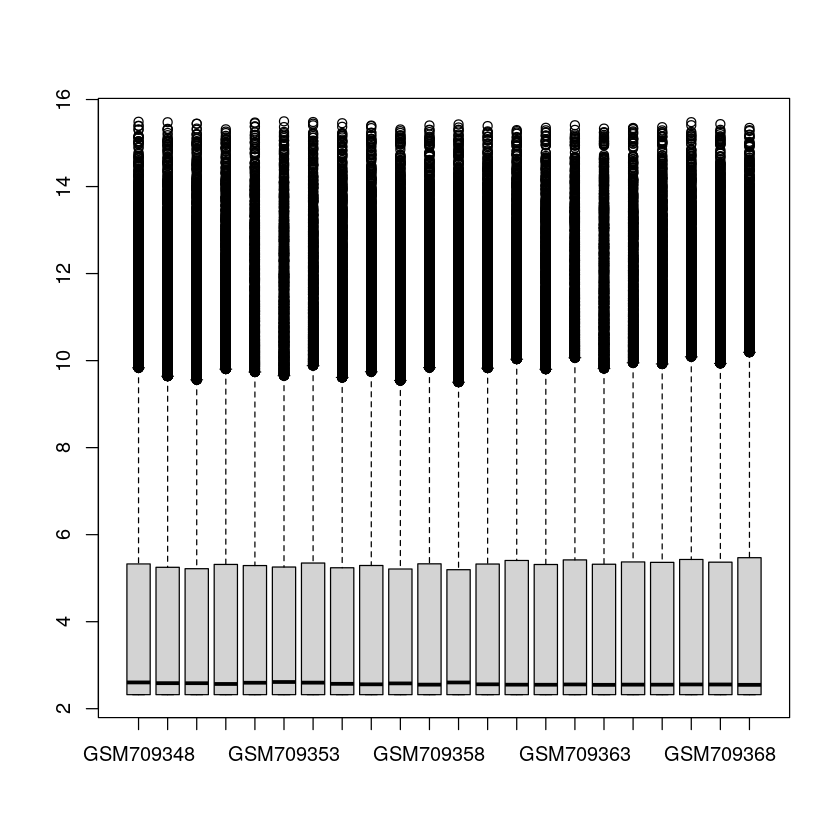

In [6]:
boxplot(exprs(gset))

The data have been log2 transformed (range between 0 to 16 typically)

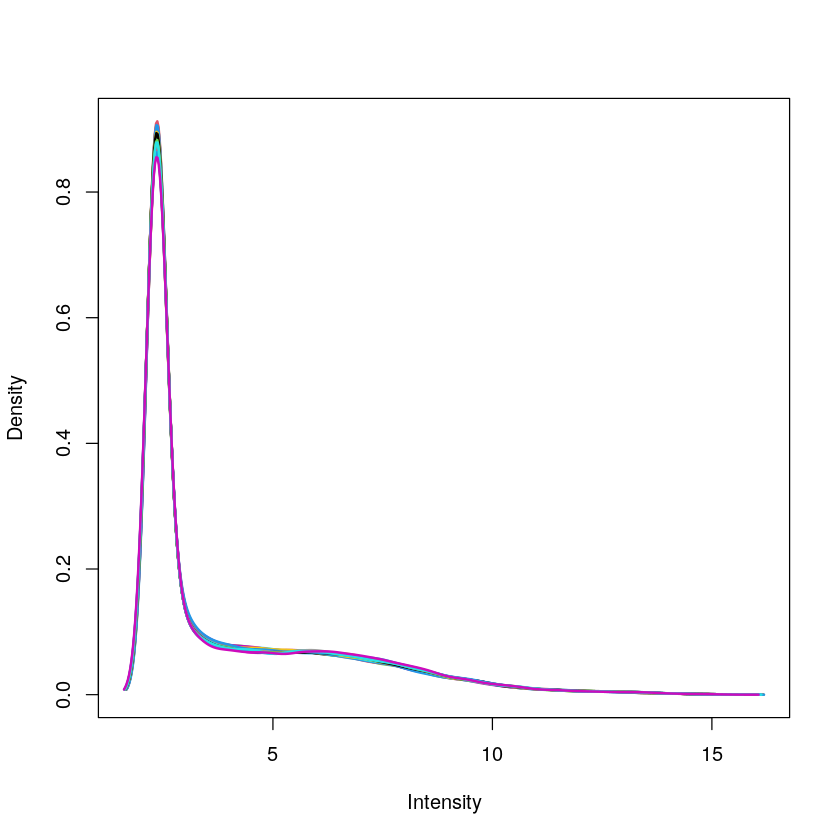

In [7]:
plotDensities(gset, legend = FALSE)

The data are normalised, here using [gcrma](https://www.bioconductor.org/packages/devel/bioc/vignettes/gcrma/inst/doc/gcrma2.0.pdf) and not quantile normalised as classically with the ```normalizeBetweenArrays()``` function.

We can see that the distribution is right skewed and here we choose to select a filter threshold of 3 for our analysis to remove genes with low mean expression across all samples: ```rowMeans(exprs(gset)) > 3```

Another less retrictive option is to first select gene that is expressed about the threshold choosen for each samples and then select genes that are expressed in more than 2 samples: ```rowSums(exprs(gset) > 3) > 2```

In [8]:
keep <- rowMeans(exprs(gset)) > 3
gset_f <- gset[keep, ]

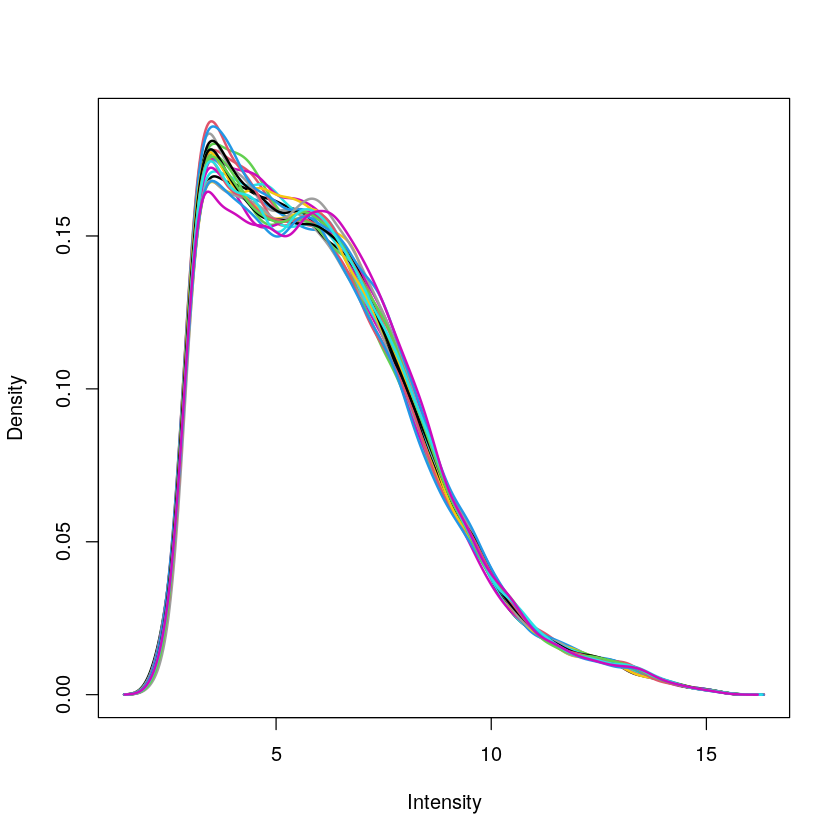

In [9]:
plotDensities(gset_f, legend = FALSE)

#### Sanity check bacth effets

We can fisrt check the correlation plot to verify that samples are separated into 2 main groups (control vs disease).  
We can use a PCA plot to assess that the type of sample (control vs disease) accounts for most of the variance (PC1) in our experiments. To perform PCA, just add ```gene.selection = 'common'``` to the ```plotMDS``` function.

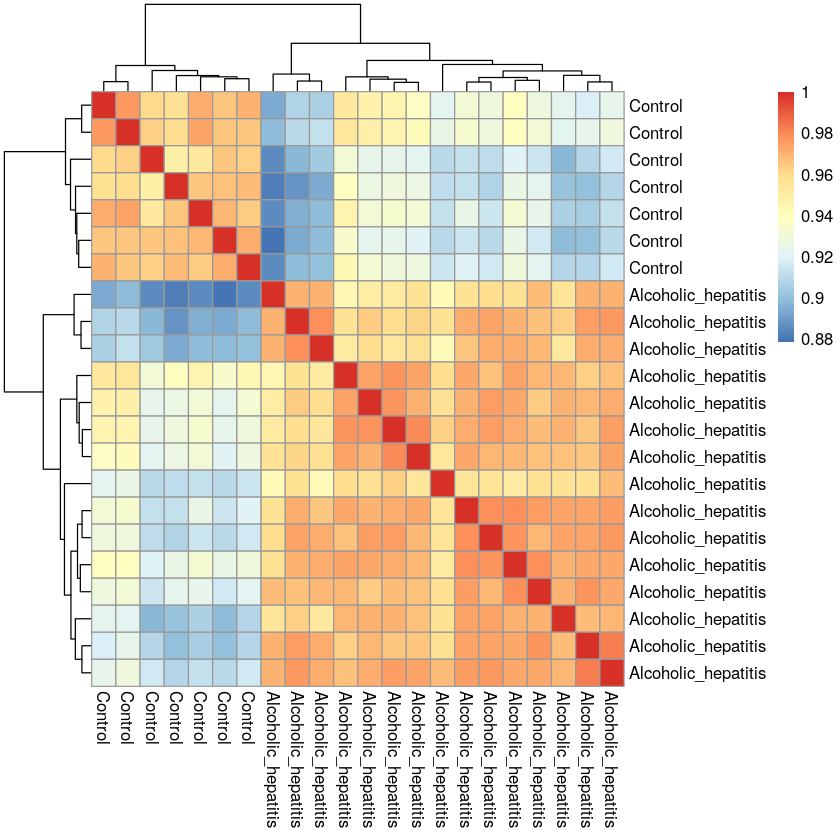

In [10]:
## argument use="c" stops an error if there are any missing data points

corMatrix <- cor(exprs(gset_f),use="c")
pheatmap(corMatrix, labels_col = gset_f$group, labels_row = gset_f$group)   

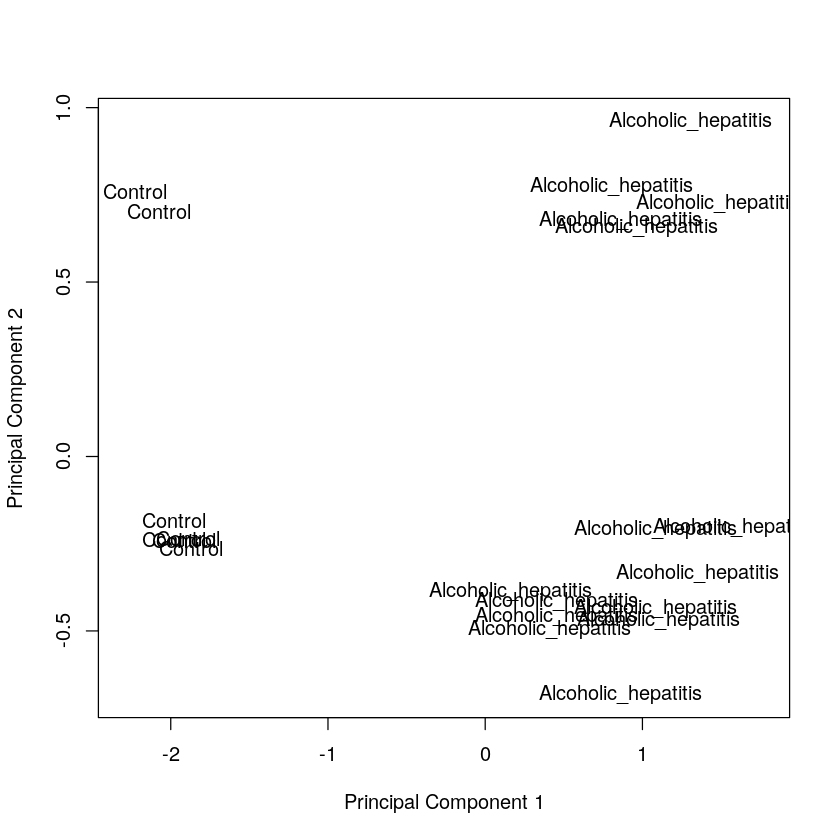

In [11]:
plotMDS(gset_f, labels=gset_f$group, gene.selection='common')

PC2 also explains the variance between two groups in both control and alcoholic hepatitis.

#### Set design matrix



In [12]:
design <- model.matrix(~group + 0, gset_f)
colnames(design) <- groups
design

,Alcoholic_hepatitis,Control
GSM709348,0,1
GSM709349,0,1
GSM709350,0,1
GSM709351,0,1
GSM709352,0,1
GSM709353,0,1
GSM709354,0,1
GSM709355,1,0
⋮,⋮,⋮
GSM709363,1,0


#### Test with array weights
Calculate weights for each **samples** to reduce the impact of outliers, based on residuals.

In [13]:
## calculate relative array weights
aw <- arrayWeights(exprs(gset_f),design)
aw

1         2         3         4         5         6         7         8 
0.6758117 1.0599702 1.0134225 0.9987555 1.0573182 0.5848962 1.0463486 1.0185453 
        9        10        11        12        13        14        15        16 
1.0354418 0.9709800 1.0039997 0.5701762 0.9608489 1.4646683 1.3962995 1.2004700 
       17        18        19        20        21        22 
1.2066774 1.2823712 1.6505449 0.6636680 1.1640203 0.7811655

#### Set up contrasts of interest

In [14]:
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
cont.matrix

,Alcoholic_hepatitis-Control
Alcoholic_hepatitis,1
Control,-1


#### Fit linear models


In [15]:
fit <- lmFit(gset_f, design)  #fit linear model to data

head(fit$coefficients)

,Alcoholic_hepatitis,Control
1007_s_at,6.158557,5.250485
1053_at,5.853633,5.412250
117_at,3.493010,3.410613
121_at,4.198217,4.182196
1294_at,4.409436,4.485300
1405_i_at,6.004170,6.817304


In [16]:
#with weight array
fit_aw <- lmFit(gset_f, design,
             weights = aw)

In [17]:
fit2 <- contrasts.fit(fit, cont.matrix) #recalculate coefficients for all contrasts (diff)

head(fit2$coefficients)

,Alcoholic_hepatitis-Control
1007_s_at,0.90807139
1053_at,0.44138294
117_at,0.08239705
121_at,0.01602093
1294_at,-0.07586368
1405_i_at,-0.81313385


In [18]:
#with weight array
fit2_aw <- contrasts.fit(fit_aw, cont.matrix) #recalculate coefficients for all contrasts (diff)

head(fit2_aw$coefficients)

,Alcoholic_hepatitis-Control
1007_s_at,0.86954329
1053_at,0.44203088
117_at,0.08674936
121_at,0.01340522
1294_at,-0.06947412
1405_i_at,-0.64971423


#### Compute t-statistics and summarise results

In [19]:
fit2 <- eBayes(fit2)

results <- decideTests(fit2)
summary(results)

       Alcoholic_hepatitis-Control
Down                          4921
NotSig                       12303
Up                            6552

In [20]:
fit2_aw <- eBayes(fit2_aw)

results <- decideTests(fit2_aw)
summary(results)

       Alcoholic_hepatitis-Control
Down                          4920
NotSig                       12397
Up                            6459

In [21]:
stats <- topTable(fit2, adjust="fdr", sort.by="B", number=nrow(fit2), p.value=0.05)

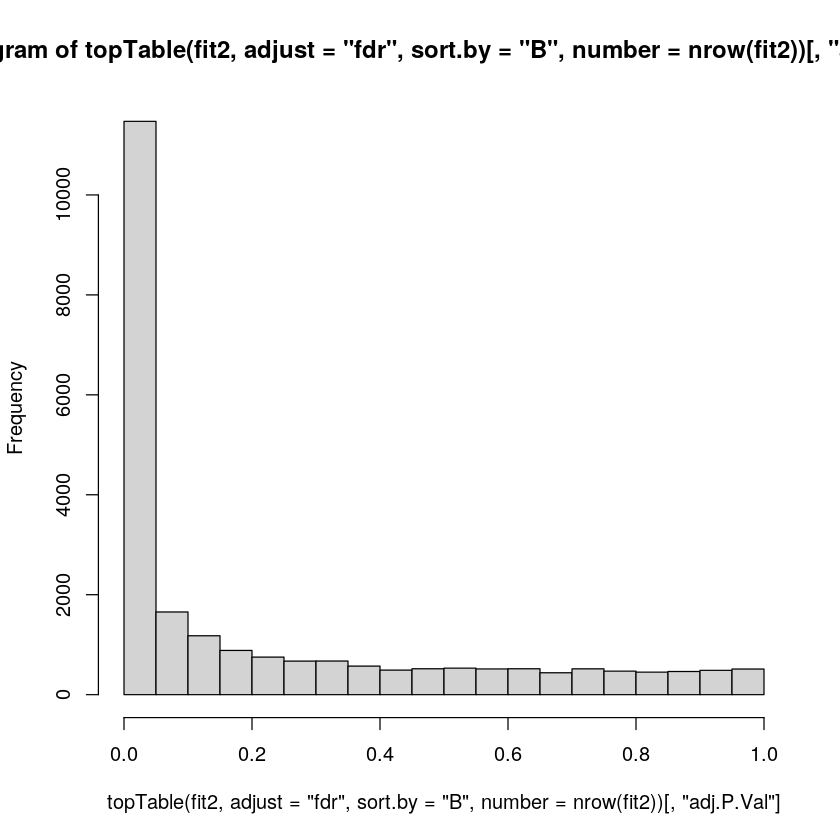

In [22]:
hist(topTable(fit2, adjust="fdr", sort.by="B", number=nrow(fit2))[, "adj.P.Val"])

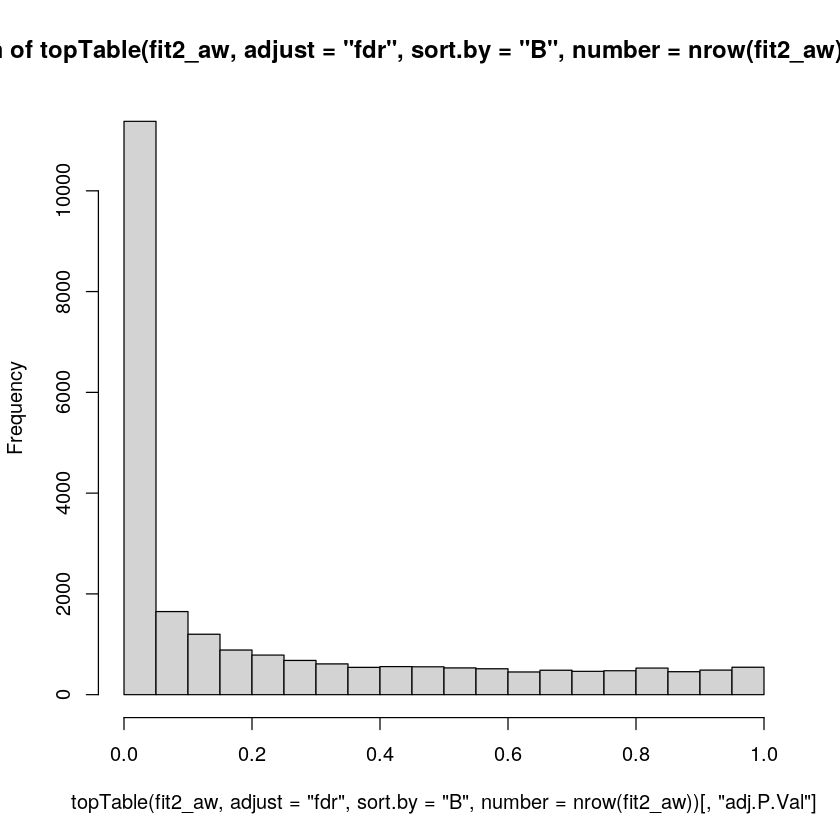

In [23]:
hist(topTable(fit2_aw, adjust="fdr", sort.by="B", number=nrow(fit2_aw))[, "adj.P.Val"])

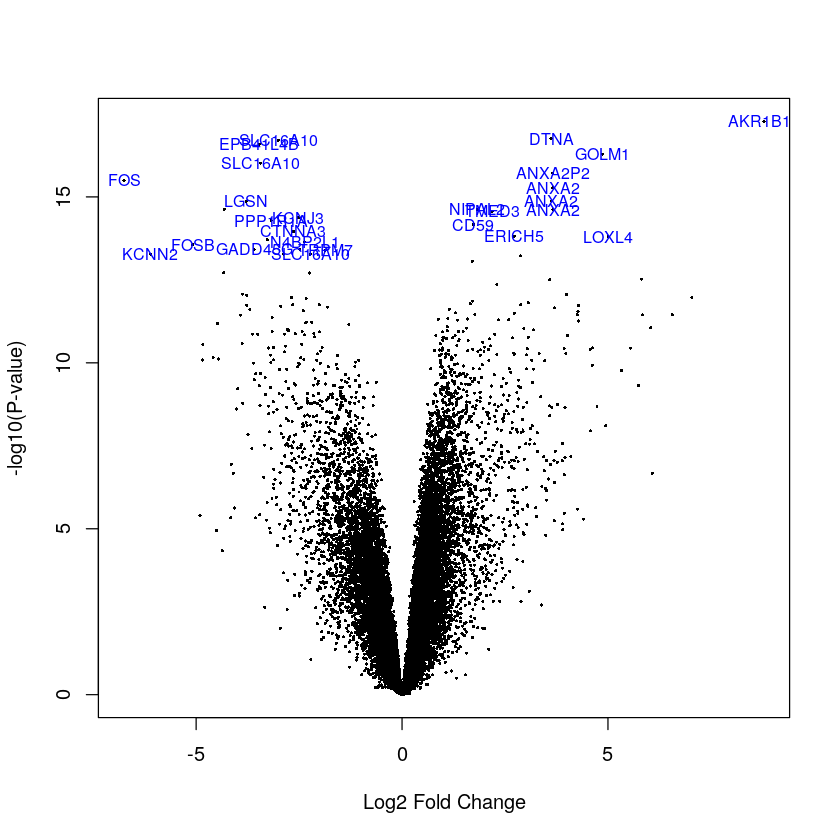

In [24]:
volcanoplot(fit2,
highlight = 30,
names = fit2$genes[, "Gene.symbol"])

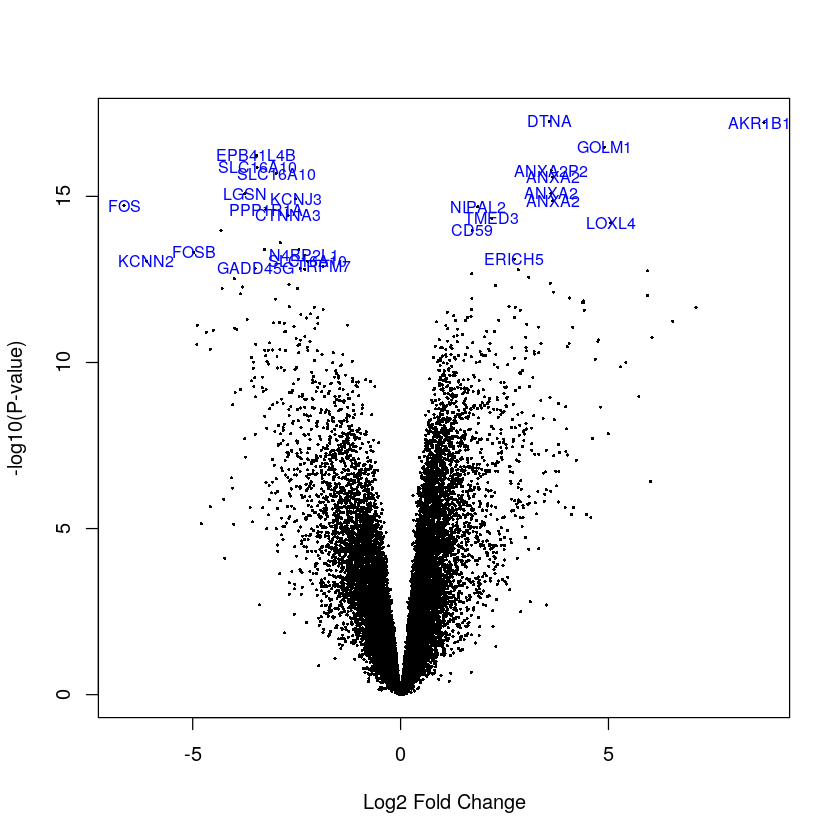

In [25]:
volcanoplot(fit2_aw,
highlight = 30,
names = fit2_aw$genes[, "Gene.symbol"])

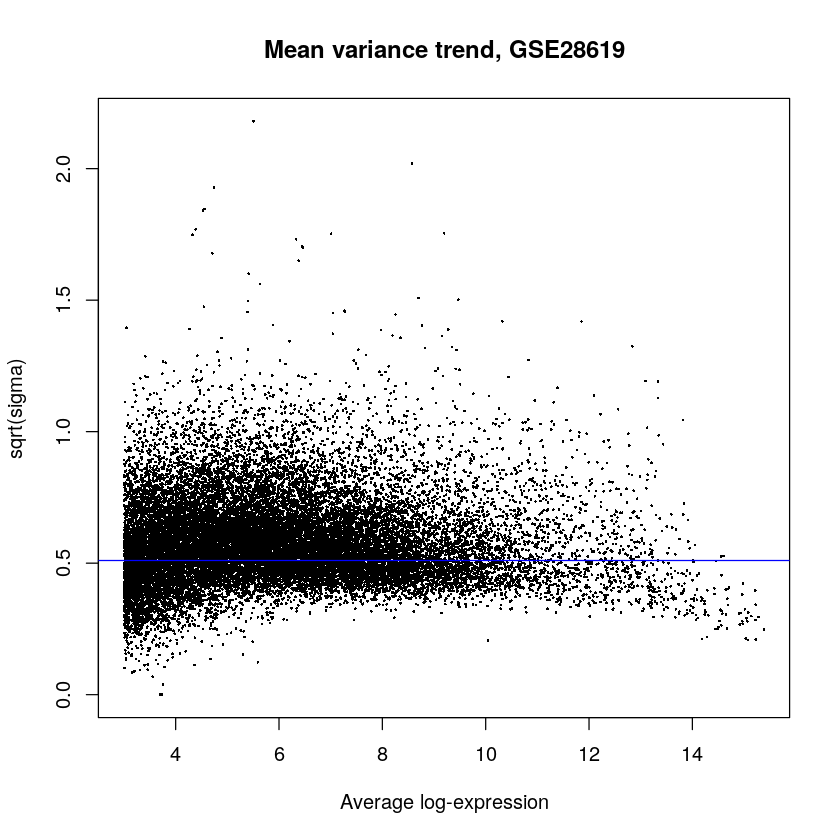

In [26]:
plotSA(fit2, main="Mean variance trend, GSE28619")

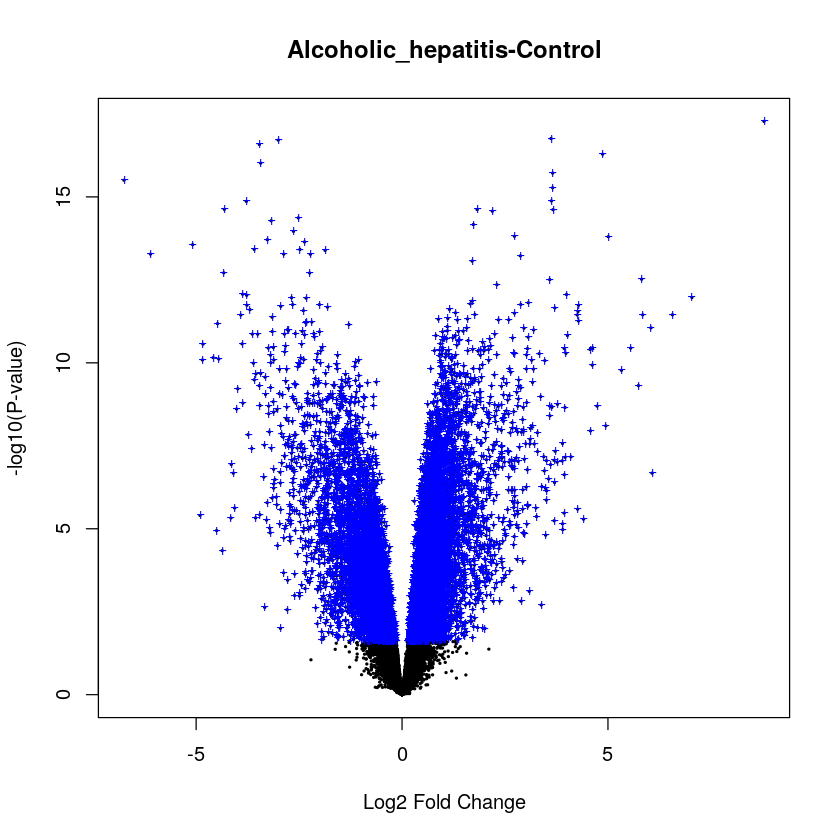

In [27]:
volcanoplot(fit2, coef=1, main=colnames(fit2)[1], pch=20,
  highlight=length(which(stats[,1]!=0)), names=rep('+', nrow(fit2)))

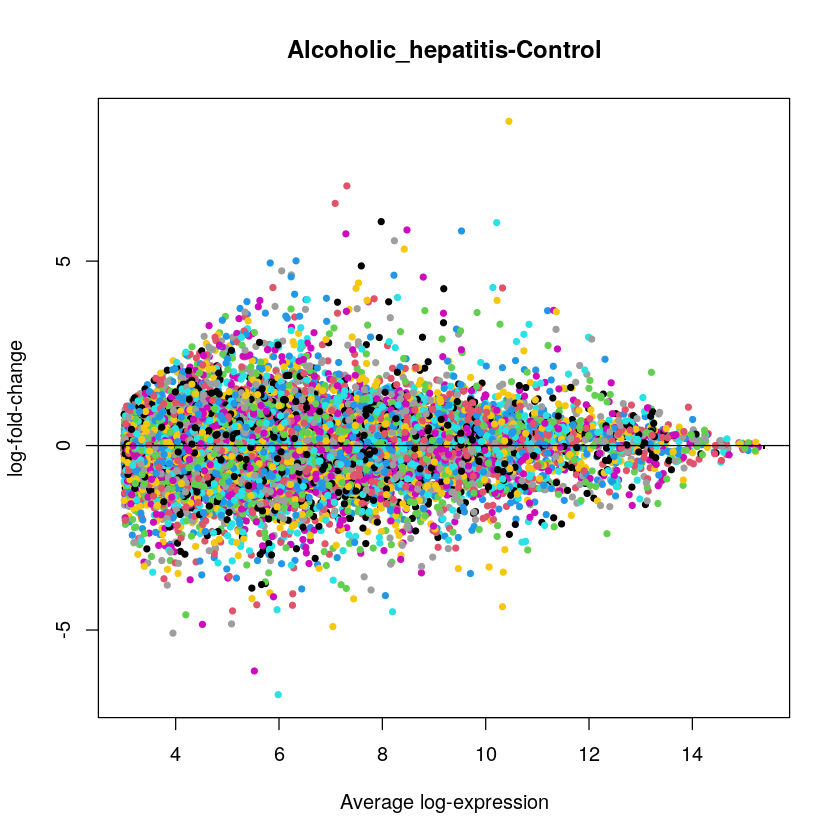

In [28]:
plotMD(fit2, column=1, status=stats[,1], legend=F, pch=20, cex=1)
abline(h=0)

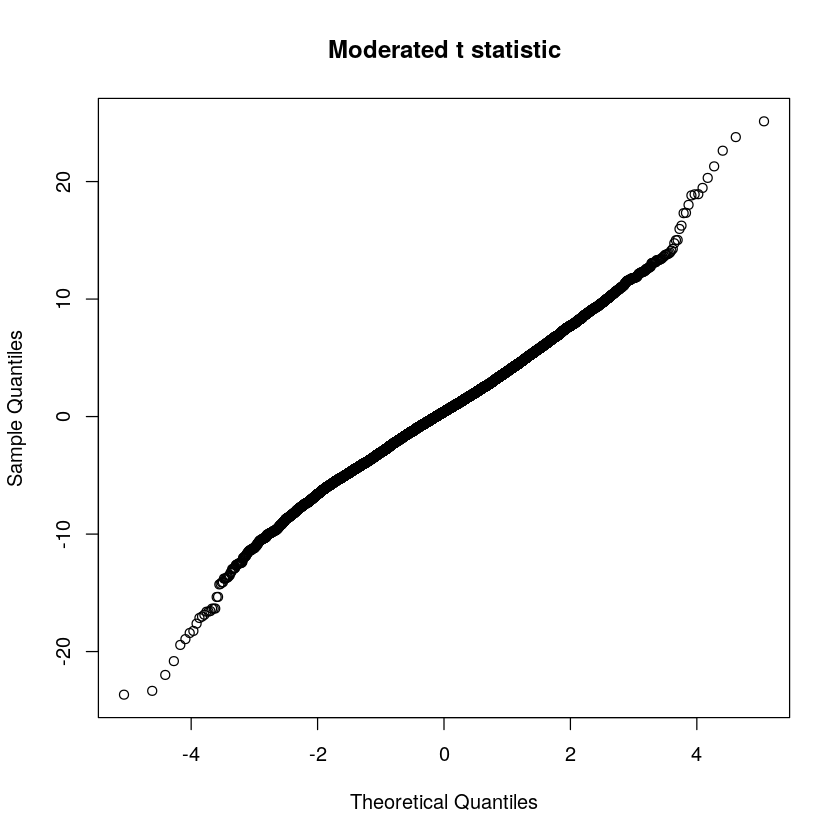

In [29]:
t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

# Analysis of PDCD1, CD274, PDCD1LG2

We are intesrested in 3 particular genes but all 3 genes have a expression inferior to 3!

In [30]:
which(fData(gset_f)[, 'Gene.symbol'] == 'PDCD1LG2'| fData(gset_f)[, 'Gene.symbol'] =='CD274'| fData(gset_f)[, 'Gene.symbol'] =='PDCD1')

integer(0)

In [31]:
which(fData(gset)[, 'Gene.symbol'] == 'PDCD1LG2'| fData(gset)[, 'Gene.symbol'] =='CD274'| fData(gset)[, 'Gene.symbol'] =='PDCD1')

[1] 17076 29334 33111 33663 36714

#### Set design matrix



In [32]:
design <- model.matrix(~group + 0, gset)
colnames(design) <- groups

#### Set up contrasts of interest

In [33]:
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)

#### Fit linear models


In [34]:
fit <- lmFit(gset, design)  #fit linear model to data

In [35]:
fit2 <- contrasts.fit(fit, cont.matrix) #recalculate coefficients for all contrasts (diff)

#### Compute t-statistics and summarise results

In [36]:
fit2 <- eBayes(fit2)

results <- decideTests(fit2)
summary(results)

       Alcoholic_hepatitis-Control
Down                          5208
NotSig                       43779
Up                            5688

In [37]:
stats <- topTable(fit2, number=nrow(fit2))
head(stats)

,ID,Gene.title,Gene.symbol,Gene.ID,UniGene.title,UniGene.symbol,UniGene.ID,Nucleotide.Title,GI,GenBank.Accession,Platform_CLONEID,Platform_ORF,Platform_SPOTID,Chromosome.location,Chromosome.annotation,GO.Function,GO.Process,GO.Component,GO.Function.ID,GO.Process.ID,GO.Component.ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
206561_s_at,206561_s_at,aldo-keto reductase family 1 member B10,AKR1B10,57016,,,,"Homo sapiens aldo-keto reductase family 1 member B10 (AKR1B10), mRNA",223468662,NM_020299,NA,NA,NA,7q33,"Chromosome 7, NC_000007.14 (134527592..134541414)",aldo-keto reductase (NADP) activity///geranylgeranyl reductase activity///indanol dehydrogenase activity///protein binding///retinal dehydrogenase activity,cellular aldehyde metabolic process///daunorubicin metabolic process///digestion///doxorubicin metabolic process///farnesol catabolic process///oxidation-reduction process///retinoid metabolic process///steroid metabolic process,cytosol///extracellular exosome///lysosome,GO:0004033///GO:0045550///GO:0047718///GO:0005515///GO:0001758,GO:0006081///GO:0044597///GO:0007586///GO:0044598///GO:0016488///GO:0055114///GO:0001523///GO:0008202,GO:0005829///GO:0070062///GO:0005764,8.789014,10.449615,24.07650,1.725956e-16,5.181046e-12,27.82892
222939_s_at,222939_s_at,solute carrier family 16 member 10,SLC16A10,117247,,,,"yw69a04.s1 Soares_placenta_8to9weeks_2NbHP8to9W Homo sapiens cDNA clone IMAGE:257454 3-, mRNA sequence",1148777,N30257,NA,NA,NA,6q21,"Chromosome 6, NC_000006.12 (111087503..111227125)",amino acid transmembrane transporter activity///aromatic amino acid transmembrane transporter activity///thyroid hormone transmembrane transporter activity///transporter activity,amino acid transmembrane transport///amino acid transport///aromatic amino acid transport///thyroid hormone transport,basolateral plasma membrane///integral component of membrane///integral component of plasma membrane///plasma membrane,GO:0015171///GO:0015173///GO:0015349///GO:0005215,GO:0003333///GO:0006865///GO:0015801///GO:0070327,GO:0016323///GO:0016021///GO:0005887///GO:0005886,-3.006673,3.531287,-23.75197,2.257541e-16,5.181046e-12,27.57305
227084_at,227084_at,dystrobrevin alpha,DTNA,1837,,,,"xz88a09.x1 NCI_CGAP_Lu24 Homo sapiens cDNA clone IMAGE:2871256 3-, mRNA sequence",6835857,AW339310,NA,NA,NA,18q12,"Chromosome 18, NC_000018.10 (34493290..34891844)",PDZ domain binding///protein binding///zinc ion binding,chemical synaptic transmission///neuromuscular synaptic transmission///signal transduction///striated muscle contraction,axon///cell junction///cytoplasm///extrinsic component of cytoplasmic side of plasma membrane///protein complex///sarcolemma///synapse,GO:0030165///GO:0005515///GO:0008270,GO:0007268///GO:0007274///GO:0007165///GO:0006941,GO:0030424///GO:0030054///GO:0005737///GO:0031234///GO:0043234///GO:0042383///GO:0045202,3.617429,5.342216,23.47660,2.842824e-16,5.181046e-12,27.35291
220524_at,220524_at,erythrocyte membrane protein band 4.1 like 4B,EPB41L4B,54566,,,,,NA,,NA,NA,NA,9q31-q32,"Chromosome 9, NC_000009.12 (109171974..109320964, complement)",cytoskeletal protein binding///structural constituent of cytoskeleton,actomyosin structure organization///positive regulation of cell adhesion///positive regulation of gene expression///positive regulation of keratinocyte migration///NOT regulation of keratinocyte proliferation///wound healing,apical part of cell///bicellular tight junction///cytoplasm///cytoskeleton///extrinsic component of membrane,GO:0008092///GO:0005200,GO:0031032///GO:0045785///GO:0010628///GO:0051549///NOT GO:0010837///GO:0042060,GO:0045177///GO:0005923///GO:0005737///GO:0005856///GO:0019898,-3.465783,4.045521,-23.08367,3.967465e-16,5.423028e-12,27.03383
217771_at,217771_at,golgi membrane protein 1,GOLM1,51280,,,,"Homo sapiens golgi membrane protein 1 (GOLM1), transcript v

In [43]:
write_csv(stats, path="results_GSE28619.csv")

> Warning: Not a good P-value counts

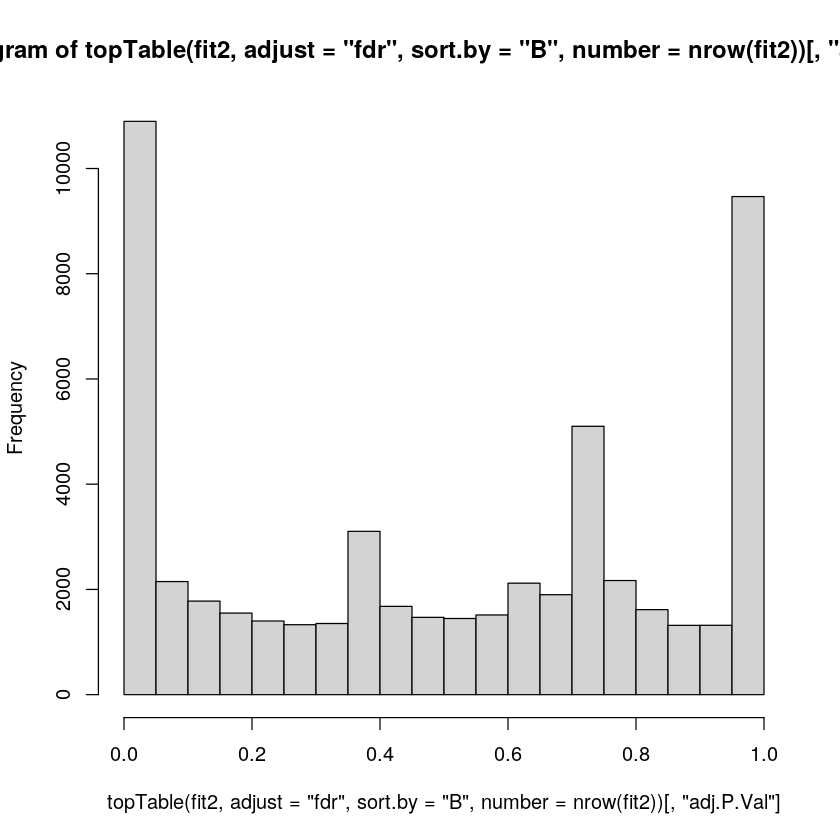

In [39]:
hist(topTable(fit2, adjust="fdr", sort.by="B", number=nrow(fit2))[, "adj.P.Val"])

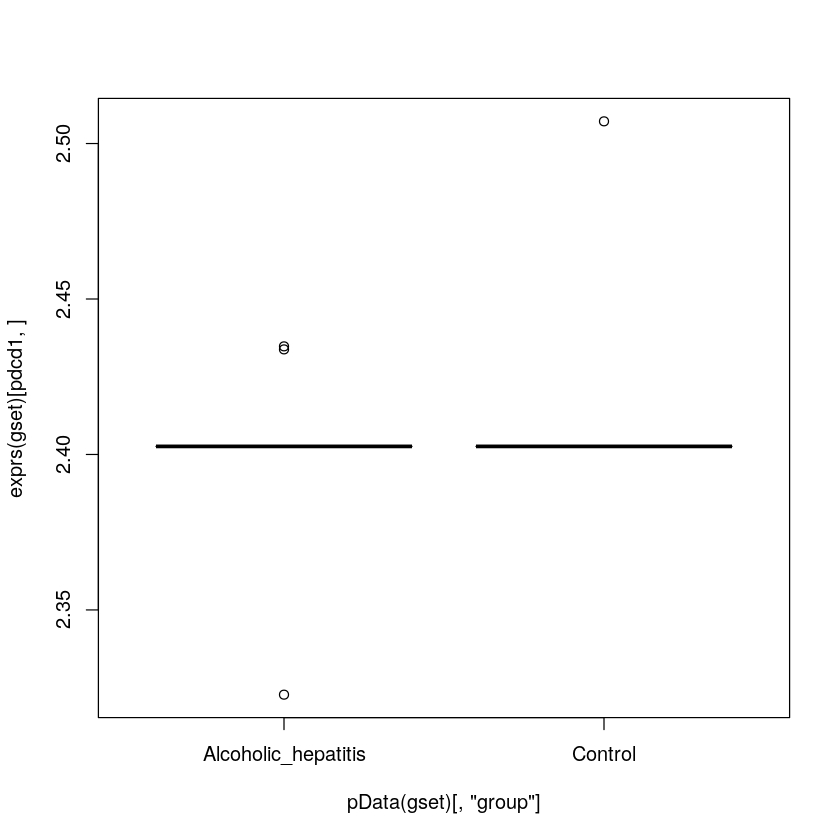

In [40]:
pdcd1 <- which(fData(gset)[, 'Gene.symbol'] == 'PDCD1')
boxplot(exprs(gset)[pdcd1, ] ~ pData(gset)[, 'group'], )